In [1]:
!pip install unrar
!unrar x /content/Dataset2.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Dataset2.rar

Creating    Dataset 2                                                 OK
Creating    Dataset 2/faringitis                                      OK
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.5818f7fd9c45883c801d938b09b29755.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.a04e34f6d58fe952bc090614f030910c.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.b120ee8edff9c00d1f305d865b733a42.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.6bd81eac38835aee94df9c1e5079d67c.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.873f55c8af860852930aef580ce9463d.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.c1c8132c26736bc54117fbc7d64a2714.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1583073772026_jpeg.rf.61c

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers


base_dir = ("/content/Dataset 2")


In [ ]:
base_dir = pathlib.Path("/content/Dataset 2")

image_extensions = ['.jpg', '.jpeg', '.png']
all_images = [p for p in base_dir.rglob('*') if p.suffix.lower() in image_extensions]

df = pd.DataFrame({
    'filename': [str(p) for p in all_images],
    'class': [p.parent.name for p in all_images]
})

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.33, stratify=temp_df['class'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


Train: 1722, Val: 494, Test: 244
Found 1722 validated image filenames belonging to 2 classes.
Found 494 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.


In [5]:
num_classes = len(train_generator.class_indices)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

callbacks = [reduce_lr, early_stop]


In [8]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 176ms/step - accuracy: 0.4802 - loss: 4.9226 - val_accuracy: 0.5992 - val_loss: 3.1692 - learning_rate: 1.0000e-04
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5476 - loss: 2.9361 - val_accuracy: 0.6012 - val_loss: 2.0353 - learning_rate: 1.0000e-04
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5471 - loss: 1.9246 - val_accuracy: 0.6012 - val_loss: 1.4321 - learning_rate: 1.0000e-04
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5874 - loss: 1.3547 - val_accuracy: 0.5992 - val_loss: 1.1251 - learning_rate: 1.0000e-04
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5970 - loss: 1.0851 - val_accuracy: 0.6134 - val_loss: 0.9652 - learning_rate: 1.0000e-04
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.6000 - loss: 0.9473 - val_accuracy: 0.6032 - val_loss: 0.8813 - learning_rate: 1.0000e-04
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - 

In [ ]:

for layer in base_model.layers[-30:]:
    layer.trainable = True

optimizer_fine = Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer_fine,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 47s 257ms/step - accuracy: 0.6229 - loss: 0.7832 - val_accuracy: 0.4008 - val_loss: 0.9428 - learning_rate: 1.0000e-05
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7632 - loss: 0.6598 - val_accuracy: 0.4008 - val_loss: 1.1913 - learning_rate: 1.0000e-05
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.8166 - loss: 0.5545 - val_accuracy: 0.4008 - val_loss: 1.4673 - learning_rate: 1.0000e-05
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.8399 - loss: 0.4960 - val_accuracy: 0.8340 - val_loss: 0.5228 - learning_rate: 1.0000e-05
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.8502 - loss: 0.4748 - val_accuracy: 0.8401 - val_loss: 0.4541 - learning_rate: 1.0000e-05
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.8668 - loss: 0.4384 - val_accuracy: 0.8441 - val_loss: 0.4538 - learning_rate: 1.0000e-05
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/st

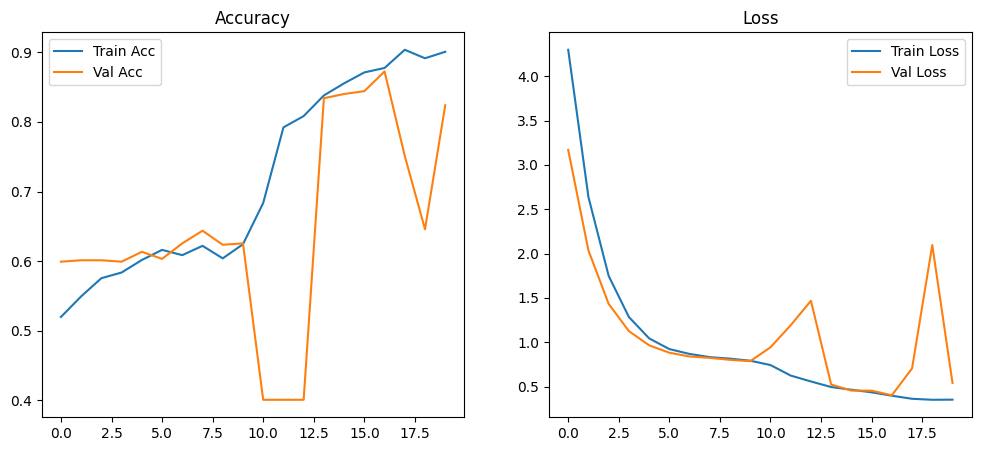

In [10]:
def plot_training(history, history_fine=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if history_fine:
        acc += history_fine.history['accuracy']
        val_acc += history_fine.history['val_accuracy']
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_training(history, history_fine)


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 387ms/step
Test Accuracy: 0.8689

Classification Report:
              precision    recall  f1-score   support

  faringitis     0.8438    0.8265    0.8351        98
      normal     0.8851    0.8973    0.8912       146

    accuracy                         0.8689       244
   macro avg     0.8644    0.8619    0.8631       244
weighted avg     0.8685    0.8689    0.8686       244



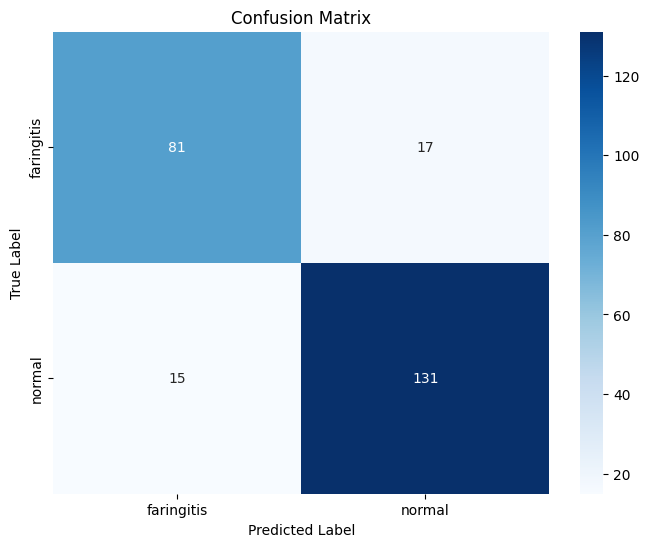

In [11]:
test_preds_probs = model.predict(test_generator, verbose=1)
test_preds = np.argmax(test_preds_probs, axis=1)
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

test_acc = accuracy_score(true_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

report = classification_report(true_labels, test_preds, target_names=class_labels, digits=4)
print("\nClassification Report:")
print(report)

cm = confusion_matrix(true_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
